# Synthesis Rate Regressions

In [1]:
import cPickle as pkl
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## 1. Get data

Regression data:

In [2]:
regression_data = pkl.load(open("../../parameters/regression_data_small.p", "rb"))

This is the data from notebook 09.

In [3]:
regression_data.columns = ['name', 'tic toc [s]', 'ORF length [nts]', 'elongation speed [nts/s]', 'transcripts', 
                           'synth. rate [molecules/s]', 'synth. rate per transcript [molecules/transcript/s]', 
                           'tAI', 'p_init', 'elongation rate [1/s]', 'time per initiation [s]', 
                           'time per protein [s]']

"Experimental" synthesis rates (https://www.ncbi.nlm.nih.gov/pubmed/12660367):

In [4]:
synth_arava = pd.DataFrame(pd.Series(pkl.load(open("../../parameters/prot_arava.p", "rb"))))
synth_arava.columns = ['synth. rate exp. [molecules/s]']

In [5]:
synth_arava.tail()

,synth. rate exp. [molecules/s]
YPR199C,0.079946
YPR200C,0.224314
YPR202W,0.002615
YPR203W,0.051853
YPR204W,0.001113


In [6]:
regression_data = pd.merge(regression_data, synth_arava, left_on='name', right_index=True, how='left')

In [7]:
regression_data['synth. rate exp. per transcript [molecules/s]'] = regression_data['synth. rate exp. [molecules/s]'] / regression_data['transcripts']

In [8]:
regression_data.tail()

,name,tic toc [s],ORF length [nts],elongation speed [nts/s],transcripts,synth. rate [molecules/s],synth. rate per transcript [molecules/transcript/s],tAI,p_init,elongation rate [1/s],time per initiation [s],time per protein [s],synth. rate exp. [molecules/s],synth. rate exp. per transcript [molecules/s]
4470,YJL081C,71.884435,1470,20.449490,5,0.150287,0.030057,0.375582,9.111658e-07,0.013911,1.097495e+06,33.269598,0.072179,0.014436
4471,YMR127C,60.685714,1017,16.758475,1,0.022414,0.022414,0.323240,5.499448e-07,0.016478,1.818364e+06,44.615385,0.062877,0.062877
4472,YPL013C,19.936467,366,18.358318,5,0.318984,0.063797,0.308066,2.289991e-06,0.050159,4.366829e+05,15.674775,NaN,NaN
4473,YLR440C,97.862222,2130,21.765294,2,0.072126,0.036063,0.368466,1.186173e-06,0.010218,8.430470e+05,27.729084,0.000000,0.000000
4474,YLR192C,26.893313,798,29.672804,22,2.742112,0.124641,0.510948,4.290874e-06,0.037184,2.330528e+05,8.023014,0.444057,0.020184


## 2. Linear regression setup

In [9]:
ntest = 100

Utility function to produce regression data from a data frame:

In [10]:
def regression_data_from_frame(frame, x_list, y, ntest=100):
    regression_x = np.array(frame[x_list])

    # Split the data into training/testing sets
    x_train = regression_x[:-ntest]
    x_test = regression_x[-ntest:]

    # Split the targets into training/testing sets
    y_train = np.array(frame[y][:-ntest])
    y_test = np.array(frame[y][-ntest:])
    return x_train, y_train, x_test, y_test

TODO: residuals!

In [11]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, xlog=True, ylog=True,
                 xmax=False, ymax=False):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)
            
    if xmax:
        ax.set_xlim(right=xmax)
    if ymax:
        ax.set_ylim(top=ymax)

    scat = plt.scatter(xs, ys, color='b', alpha=alpha)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs, missing='raise', return_sorted=True)[:,1]
    
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

From https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression to include $p$ and $t$ values:

In [12]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

Doesn't seem to work...

In [16]:
def build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True):
    # Create linear regression object
    #regr = LinearRegression(fit_intercept=fit_intercept)
    regr = linear_model.LinearRegression(fit_intercept=fit_intercept)

    # Train the model using the training sets
    regr.fit(x_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(x_test)

    # The coefficients
    print 'Coefficients: ', regr.coef_
    print 'Intercept: ', regr.intercept_
    #print '$p$ values:', regr.p
    #print '$t$ values:', regr.t

    # The mean squared error
    print "Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)

    # Explained variance score: 1 is perfect prediction
    print 'R² score: %.2f' % r2_score(y_test, y_pred)
    
    return regr

## 3. Build some models

### 3.1 Univariate models against synthetic rates

#### 3.1.1 tAI

In [17]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data, 
                                                              ['tAI'], 
                                                              'synth. rate per transcript [molecules/transcript/s]', 
                                                              ntest=100)

In [18]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 0.38154187]
Intercept:  -0.102180635748
Mean squared error: 0.00
R² score: 0.52


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
tai_dict = pd.Series(regression_data.tAI.values, index=regression_data.name).to_dict()

In [20]:
rates_dict = pd.Series(regression_data['synth. rate per transcript [molecules/transcript/s]'].values, 
                       index=regression_data.name).to_dict()

4475


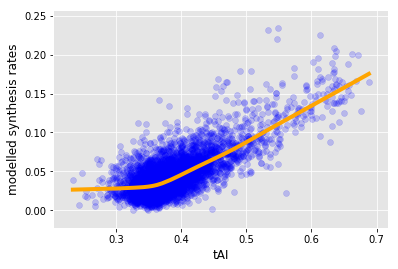

In [21]:
scatter_dicts(tai_dict, rates_dict, xaxislabel='tAI', yaxislabel='modelled synthesis rates', fontsize=None, alpha=0.2, 
              xlog=False, ylog=False, xmax=False, ymax=False)

#### 3.1.2 $p_I$

In [22]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data, 
                                                              ['p_init'], 
                                                              'synth. rate per transcript [molecules/transcript/s]', 
                                                              ntest=100)

In [23]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 27584.3509447]
Intercept:  0.00354864175085
Mean squared error: 0.00
R² score: 0.99


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=False)

Coefficients:  [ 29140.88338432]
Intercept:  0.0
Mean squared error: 0.00
R² score: 0.99


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [25]:
p_init_dict = pd.Series(regression_data.p_init.values, index=regression_data.name).to_dict()

4475


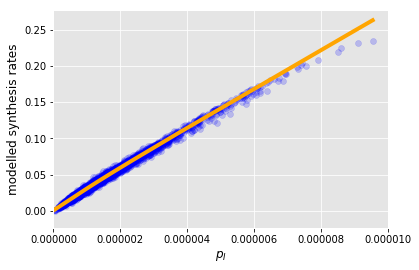

In [26]:
scatter_dicts(p_init_dict, rates_dict, xaxislabel='$p_I$', yaxislabel='modelled synthesis rates', fontsize=None, alpha=0.2, 
              xlog=False, ylog=False, xmax=0.00001, ymax=False)

### 3.2 Univariate models against experimental rates

#### 3.2.1 tAI

In [27]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. per transcript [molecules/s]'].notnull()], 
                                                              ['tAI'], 
                                                              'synth. rate exp. per transcript [molecules/s]', 
                                                              ntest=100)

In [28]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [-0.10892593]
Intercept:  0.0803804666481
Mean squared error: 0.00
R² score: 0.03


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()], 
                                                              ['tAI'], 
                                                              'synth. rate exp. [molecules/s]', 
                                                              ntest=100)

In [30]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 7.88581603]
Intercept:  -2.808006281
Mean squared error: 0.19
R² score: 0.43


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Interesting - the unnormalized works, the normalized does not; TODO: check Arava et al. (2003) paper!

In [31]:
rates_exp_dict = pd.Series(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()]['synth. rate exp. [molecules/s]'].values, 
                       index=regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()].name).to_dict()

4228


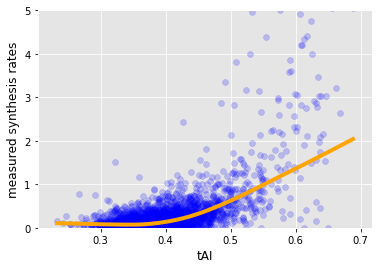

In [32]:
scatter_dicts(tai_dict, rates_exp_dict, xaxislabel='tAI', yaxislabel='measured synthesis rates', fontsize=None, alpha=0.2, 
              xlog=False, ylog=False, xmax=None, ymax=5)

#### 3.2.2 $p_I$

In [33]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. per transcript [molecules/s]'].notnull()], 
                                                              ['p_init'], 
                                                              'synth. rate exp. per transcript [molecules/s]', 
                                                              ntest=100)

In [34]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 4358.97672646]
Intercept:  0.0311422680025
Mean squared error: 0.00
R² score: -0.02


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()], 
                                                              ['p_init'], 
                                                              'synth. rate exp. [molecules/s]', 
                                                              ntest=100)

In [36]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 412838.91734464]
Intercept:  -0.379220718624
Mean squared error: 0.18
R² score: 0.46


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

4228


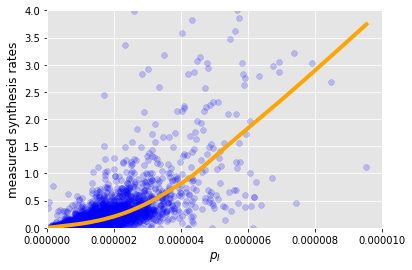

In [37]:
scatter_dicts(p_init_dict, rates_exp_dict, xaxislabel='$p_I$', yaxislabel='measured synthesis rates', fontsize=None, alpha=0.2, 
              xlog=False, ylog=False, xmax=0.00001, ymax=4)

In [38]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=False)

Coefficients:  [ 246693.46750851]
Intercept:  0.0
Mean squared error: 0.21
R² score: 0.37


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

### 3.3 Multivariate models ($p_I$, tAI) against synthetic rates

In [39]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data, 
                                                              ['p_init', 'tAI'], 
                                                              'synth. rate per transcript [molecules/transcript/s]', 
                                                              ntest=100)

In [40]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [  2.71259851e+04   1.12044668e-02]
Intercept:  -0.000103149288903
Mean squared error: 0.00
R² score: 0.99


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Standardize independent variables to find influence:

In [41]:
def normalize(df):
    return (df - df.mean()) / df.std()

In [42]:
regression_data['p_init_norm'] = normalize(regression_data['p_init'])
regression_data['tAI_norm'] = normalize(regression_data['tAI'])
regression_data['ORF length_norm'] = normalize(regression_data['ORF length [nts]'])

In [43]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data, 
                                                              ['p_init_norm', 'tAI_norm'], 
                                                              'synth. rate per transcript [molecules/transcript/s]', 
                                                              ntest=100)

In [44]:
regr = build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 0.02875654  0.00065014]
Intercept:  0.046432147338
Mean squared error: 0.00
R² score: 0.99


In [45]:
regr.coef_[0] / regr.coef_[1]

44.231482812858033

The coefficient on $p_I$ is 44x bigger than the coefficient on tAI.

### 3.4 Multivariate models ($p_I$, tAI) against experimental rates

In [46]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()], 
                                                              ['p_init', 'tAI'], 
                                                              'synth. rate exp. per transcript [molecules/s]', 
                                                              ntest=100)

In [47]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [  2.01318090e+04  -3.85999557e-01]
Intercept:  0.156943809494
Mean squared error: 0.00
R² score: 0.07


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()], 
                                                              ['p_init', 'tAI'], 
                                                              'synth. rate exp. [molecules/s]', 
                                                              ntest=100)

In [49]:
build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [  2.07046596e+05   5.03623847e+00]
Intercept:  -2.02058675313
Mean squared error: 0.16
R² score: 0.50


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data[regression_data['synth. rate exp. [molecules/s]'].notnull()], 
                                                              ['p_init_norm', 'tAI_norm'], 
                                                              'synth. rate exp. [molecules/s]', 
                                                              ntest=100)

In [51]:
regr = build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 0.21949223  0.29222688]
Intercept:  0.262591920129
Mean squared error: 0.16
R² score: 0.50


In [52]:
regr.coef_[0] / regr.coef_[1]

0.75110211304803087

Approximately the same influence by both variables!

In [53]:
pkl.dump(regression_data, open("../../parameters/regression_data.p", "wb"))

### 3.5 Plot "score" ($p_I$, tAI) against experimental synthesis rate

In [54]:
regr.intercept_

0.26259192012906196

In [55]:
regr.coef_

array([ 0.21949223,  0.29222688])

In [56]:
regression_data['score'] = regr.coef_[0] * regression_data['p_init_norm'] + \
                           regr.coef_[1] * regression_data['tAI_norm'] + regr.intercept_

In [57]:
score_dict = dict(zip(regression_data['name'], regression_data['score']))

4228


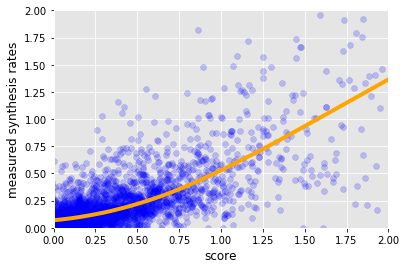

In [58]:
scatter_dicts(score_dict, rates_exp_dict, xaxislabel='score', yaxislabel='measured synthesis rates', fontsize=None, alpha=0.2, 
              xlog=False, ylog=False, xmax=2, ymax=2)

### 3.6 modelled synthesis rate ~ tAI + $p_I$ + ORF length + transcript abundance

In [59]:
x_train, y_train, x_test, y_test = regression_data_from_frame(regression_data, 
                                                              ['p_init_norm', 'tAI_norm', 'ORF length_norm'], 
                                                              'synth. rate per transcript [molecules/transcript/s]', 
                                                              ntest=100)

In [60]:
regr = build_linear_model(x_train, y_train, x_test, y_test, fit_intercept=True)

Coefficients:  [ 0.02832399  0.00093718 -0.00051065]
Intercept:  0.0464311669431
Mean squared error: 0.00
R² score: 0.99


### 3.7 measured synthesis rate ~ tAI + $p_I$ + ORF length + transcript abundance

### 3.8 modelled synthesis rate per transcript ~ tAI + $p_I$ + ORF length

### 3.9 measured synthesis rate per transcript ~ tAI + $p_I$ + ORF length